# Varied audience model

In [1]:
import numpy as np
from memo import memo

import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import IntEnum

from tqdm import tqdm


sns.set_context("talk")

## Load data and fit model

In [2]:
data = pd.read_csv("../data/3pp/varied_audience/selection_trials_clean.csv"
                   ).rename(columns={"item_id": "tangram_set"})

data.loc[data["response.earlier"] == "earlier", "response.earlier"] = 1
data.loc[data["response.earlier"] == "later", "response.earlier"] = 0
data["response.earlier"] = data["response.earlier"].astype(int)

Get the relevant stuff from the data

In [3]:
refer_mask = data["goal"] == "refer"
social_mask = data["goal"] == "social"

# Convert columns for the 'refer' subset
n_in_refer = jnp.array(data.loc[refer_mask, "n_ingroup"].values)
n_out_refer = jnp.array(data.loc[refer_mask, "n_outgroup"].values)
resp_refer = jnp.array(data.loc[refer_mask, "response.earlier"].values)

# Convert columns for the 'social' subset
n_in_social = jnp.array(data.loc[social_mask, "n_ingroup"].values)
n_out_social = jnp.array(data.loc[social_mask, "n_outgroup"].values)
resp_social = jnp.array(data.loc[social_mask, "response.earlier"].values)

In [4]:
class ModelType(IntEnum):
    BASE = 0
    SOCIAL = 1

In [5]:
# type: ignore

class Choices(IntEnum):
    Earlier = 0
    Later = 1


@jax.jit
def ref_info(n_ingroup, n_outgroup, utterance):
    earlier_utility = n_ingroup + n_outgroup
    later_utility = n_ingroup
    return jnp.array([earlier_utility, later_utility])[utterance]


@jax.jit
def social_info(n_ingroup, n_outgroup, utterance):
    earlier_utility = 0
    later_utility = n_ingroup
    return jnp.array([earlier_utility, later_utility])[utterance]


@jax.jit
def cost(utterance):
    return jnp.array([1, 0])[utterance]


@memo
def speaker[utterance: Choices](n_ingroup, n_outgroup, alpha, w_r, w_s, w_c):
    cast: [speaker]
    speaker: chooses(
        utterance in Choices,
        wpp=exp(
            alpha
            * (
                w_r * ref_info(n_ingroup, n_outgroup, utterance)
                + w_s * social_info(n_ingroup, n_outgroup, utterance)
                - w_c * cost(utterance)
            )
        ),
    )
    return Pr[speaker.utterance == utterance]


In [6]:
@jax.jit
def speaker_refer(n_ingroup, n_outgroup, w_r, w_c):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=w_r,
        w_s=0,
        w_c=w_c,
    )[0]

@jax.jit
def speaker_social(n_ingroup, n_outgroup, w_r, w_s, w_c):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=0,
        w_s=w_s,
        w_c=w_c,
    )[0]

# functions for generating predictions over the whole dataset
speaker_refer_vmap = jax.vmap(speaker_refer, in_axes=(0, 0, None, None))
speaker_social_vmap = jax.vmap(speaker_social, in_axes=(0, 0, None, None, None))

Compute preds on the whole dataset

In [7]:
@jax.jit
def predict_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c):
    preds_refer = speaker_refer_vmap(n_in_refer, n_out_refer, w_r, w_c)
    preds_social = jax.lax.cond(
        model_type == ModelType.SOCIAL,
        lambda _: speaker_social_vmap(n_in_social, n_out_social, w_r, w_s, w_c),
        lambda _: speaker_refer_vmap(n_in_social, n_out_social, w_r, w_c),
        operand=None
    )
    return preds_refer, preds_social

@jax.jit
def NLL_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social, w_r, w_s, w_c):
    preds_refer, preds_social = predict_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c)
    eps = 1e-7
    preds_refer_clipped = jnp.clip(preds_refer, eps, 1 - eps)
    preds_social_clipped = jnp.clip(preds_social, eps, 1 - eps)
    nll_refer = -jnp.sum(resp_refer * jnp.log(preds_refer_clipped) + (1 - resp_refer) * jnp.log(1 - preds_refer_clipped))
    nll_social = -jnp.sum(resp_social * jnp.log(preds_social_clipped) + (1 - resp_social) * jnp.log(1 - preds_social_clipped))
    return nll_refer + nll_social

In [8]:
def fit_params(model_type, params_list, n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social):
    nlls = []
    for params in tqdm(params_list):
        nll = NLL_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social, *params)
        nlls.append(nll)
    
    nlls = jnp.array(nlls)
    min_idx = jnp.argmin(nlls)
    best_params = params_list[min_idx]
    best_nll = nlls[min_idx]
    return best_params, best_nll

In [9]:
w_rs = np.arange(0, 5, 0.1)
w_ss = np.arange(0, 5, 0.1)
w_cs = np.arange(0, 5, 0.1)
params_list = [(w_r, w_s, w_c) for w_r in w_rs for w_s in w_ss for w_c in w_cs]

In [10]:
best_params_social, best_nll_social = fit_params(
    params_list=params_list,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    resp_refer=resp_refer,
    resp_social=resp_social,
    model_type=ModelType.SOCIAL
)
best_params_social, best_nll_social

100%|██████████| 125000/125000 [00:12<00:00, 9722.01it/s] 


((0.1, 0.2, 0.0), Array(5940.9414, dtype=float32))

In [11]:
best_w_r_social, best_w_s_social, best_w_c_social = best_params_social

In [12]:
best_params_base, best_nll_base = fit_params(
    params_list=params_list,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    resp_refer=resp_refer,
    resp_social=resp_social,
    model_type=ModelType.BASE
)
best_params_base, best_nll_base

100%|██████████| 125000/125000 [00:09<00:00, 12600.85it/s]


((0.1, 0.0, 0.30000000000000004), Array(6453.3867, dtype=float32))

In [13]:
best_w_r_base, best_w_s_base, best_w_c_base = best_params_base

Generate model predictions (one for each data point)

In [14]:
preds_refer_social, preds_social_social = predict_all(
    model_type=ModelType.SOCIAL,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    w_r=best_w_r_social,
    w_s=best_w_s_social,
    w_c=best_w_c_social
)

preds_refer_base, preds_social_base = predict_all(
    model_type=ModelType.BASE,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    w_r=best_w_r_base,
    w_s=best_w_s_base,
    w_c=best_w_c_base
)

In [15]:
# Put the preds in a dataframe
preds_df_social = pd.concat(
    [
        pd.DataFrame(
            {
                "model": "social",
                "goal": "refer",
                "n_ingroup": n_in_refer,
                "n_outgroup": n_out_refer,
                "p_earlier": preds_refer_social,
            }
        ),
        pd.DataFrame(
            {
                "model": "social",
                "goal": "social",
                "n_ingroup": n_in_social,
                "n_outgroup": n_out_social,
                "p_earlier": preds_social_social,
            }
        ),
    ]
)

preds_df_base = pd.concat(
    [
        pd.DataFrame(
            {
                "model": "base",
                "goal": "refer",
                "n_ingroup": n_in_refer,
                "n_outgroup": n_out_refer,
                "p_earlier": preds_refer_base,
            }
        ),
        pd.DataFrame(
            {
                "model": "base",
                "goal": "social",
                "n_ingroup": n_in_social,
                "n_outgroup": n_out_social,
                "p_earlier": preds_social_base,
            }
        ),
    ]
)


preds_df = pd.concat([preds_df_social, preds_df_base])

In [16]:
preds_df['prop_naive'] = preds_df['n_outgroup'] / (preds_df['n_outgroup'] + preds_df['n_ingroup'])

In [17]:
preds_df

,model,goal,n_ingroup,n_outgroup,p_earlier,prop_naive
0,social,refer,0,1,0.524979,1.000000
1,social,refer,3,8,0.689974,0.727273
2,social,refer,2,16,0.832018,0.888889
3,social,refer,2,2,0.549834,0.500000
4,social,refer,1,4,0.598688,0.800000
...,...,...,...,...,...,...
4291,base,social,3,4,0.524979,0.571429
4292,base,social,1,4,0.524979,0.800000
4293,base,social,3,0,0.425557,0.000000
4294,base,social,4,1,0.450166,0.200000


Text(0.5, 1.2, 'Best-fitting model predictions, social model\nBest $w_r= 0.1$, $w_s= 0.2$, $w_c= 0.0$, NLL=5940.941')

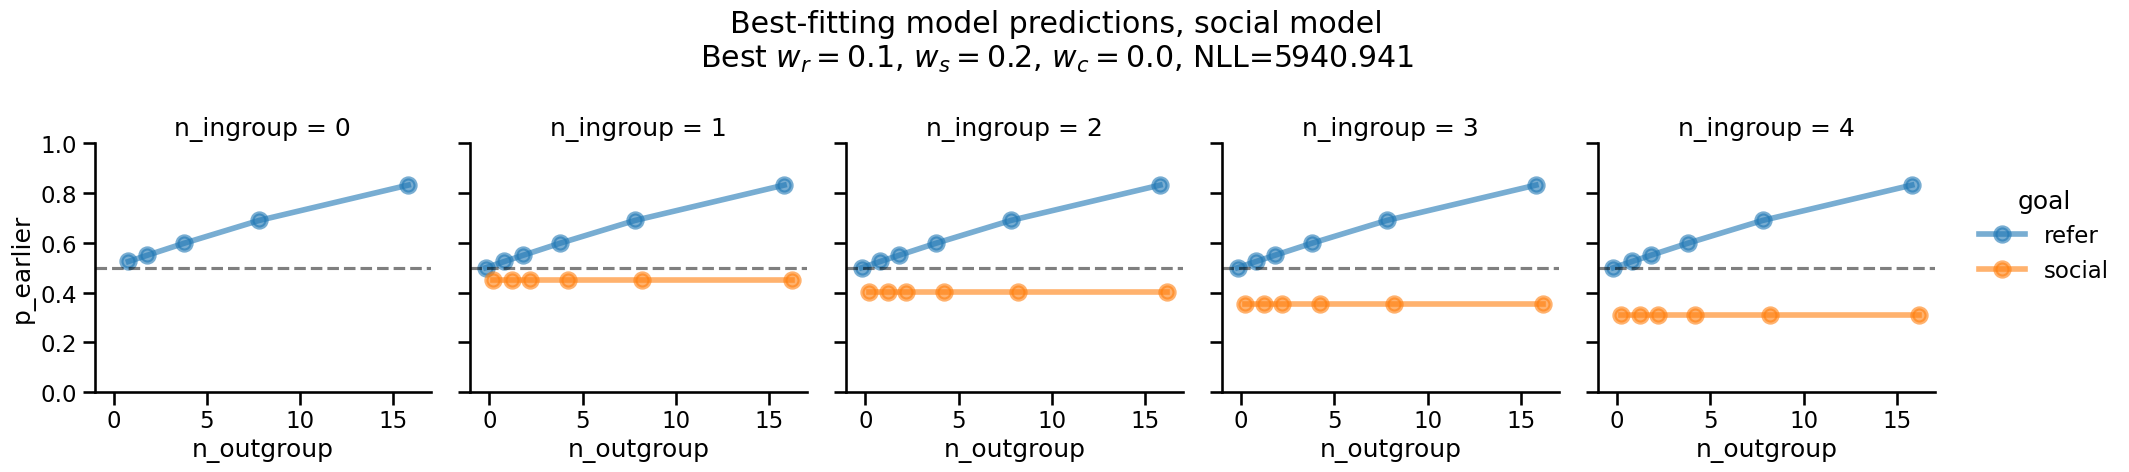

In [18]:
g = sns.catplot(
    data=preds_df[preds_df["model"] == "social"],
    x="n_outgroup",
    y="p_earlier",
    hue="goal",
    col="n_ingroup",
    kind="point",
    dodge=0.4,
    alpha=0.6,
    col_wrap=5,
    height=4,
    native_scale=True,
    log_scale=(False, False),
)
g.map(plt.axhline, y=0.5, ls="--", color="black", alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle(
    "Best-fitting model predictions, social model\nBest $w_r= {:.1f}$, $w_s= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}".format(
        best_w_r_social, best_w_s_social, best_w_c_social, best_nll_social
    ),
    y=1.2,
)

Text(0.5, 1.2, 'Best-fitting model predictions, base model\nBest $w_r= 0.1$, $w_s= 0.0$, $w_c= 0.3$, NLL=6453.387')

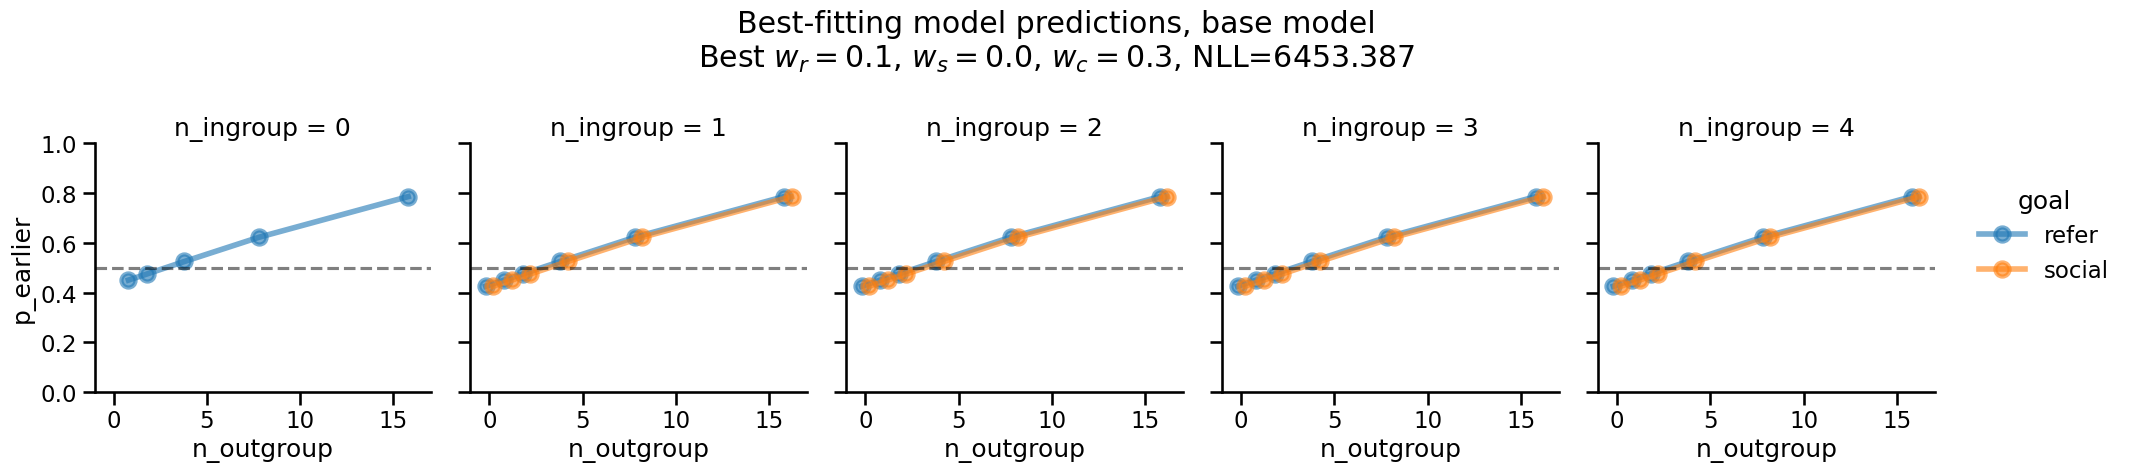

In [19]:
g = sns.catplot(
    data=preds_df[preds_df["model"] == "base"],
    x="n_outgroup",
    y="p_earlier",
    hue="goal",
    col="n_ingroup",
    kind="point",
    dodge=0.4,
    alpha=0.6,
    col_wrap=5,
    height=4,
    native_scale=True,
    log_scale=(False, False),
)
g.map(plt.axhline, y=0.5, ls="--", color="black", alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle(
    "Best-fitting model predictions, base model\nBest $w_r= {:.1f}$, $w_s= {:.1f}$, $w_c= {:.1f}$, NLL={:.3f}".format(
        best_w_r_base, best_w_s_base, best_w_c_base, best_nll_base
    ),
    y=1.2,
)

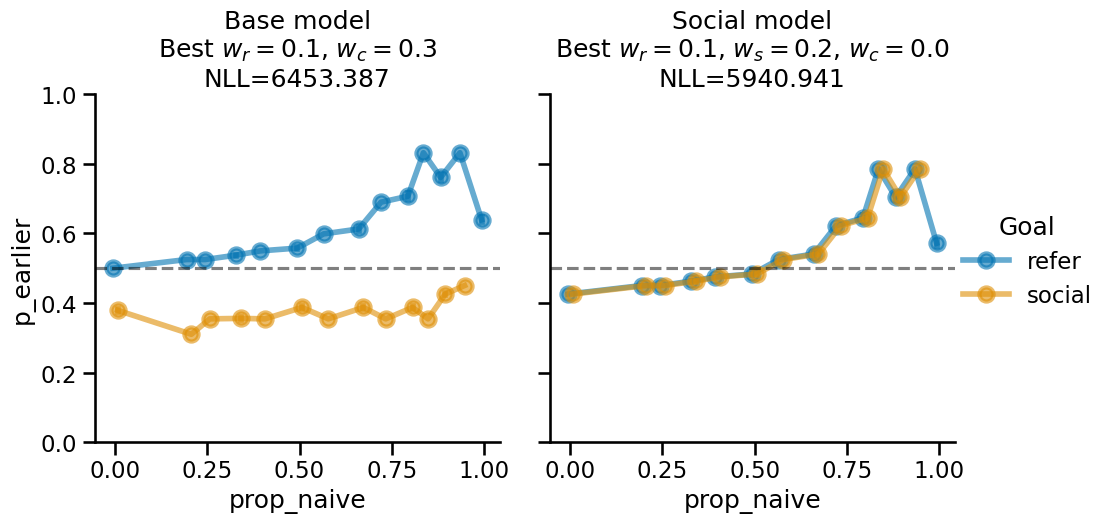

In [20]:
g = sns.FacetGrid(preds_df, col="model", sharey=True, height=5, aspect=1)

# Map the point plot onto the grid
g.map_dataframe(
    sns.pointplot, 
    x="prop_naive", 
    y="p_earlier", 
    hue="goal", 
    alpha=0.6, 
    native_scale=True, 
    dodge=0.3, 
    palette="colorblind"
)

for ax in g.axes.flat:
    ax.axhline(y=0.5, ls="--", color="black", alpha=0.5)
    ax.set_ylim(0, 1)

titles = {
    "base": "Base model\nBest $w_r= {:.1f}$, $w_c= {:.1f}$\nNLL={:.3f}".format(
        best_w_r_base, best_w_c_base, best_nll_base
    ),
    "social": "Social model\nBest $w_r= {:.1f}$, $w_s= {:.1f}$, $w_c= {:.1f}$\nNLL={:.3f}".format(
        best_w_r_social, best_w_s_social, best_w_c_social, best_nll_social
    )
}

for ax, model in zip(g.axes.flat, titles.keys()):
    ax.set_title(titles[model])

# Add a common legend
g.add_legend(title="Goal")

# Adjust layout
plt.show()

Data

In [21]:
data["prop_naive"] = data["n_outgroup"] / (data["n_outgroup"] + data["n_ingroup"])

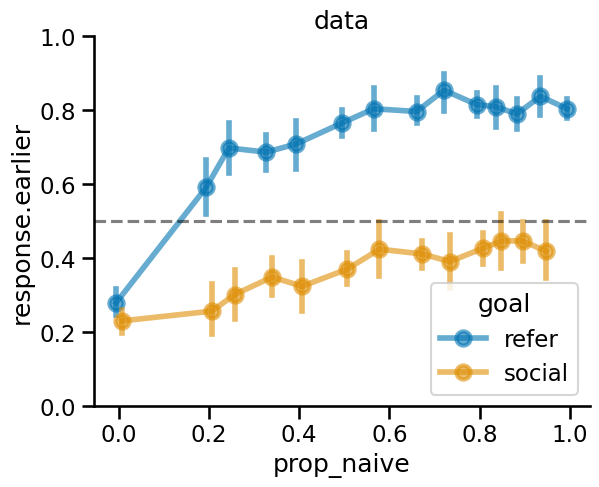

In [22]:
g = sns.pointplot(
    data=data,
    x="prop_naive",
    y="response.earlier",
    hue="goal",
    hue_order=["refer", "social"],
    dodge=0.3,
    alpha=0.6,
    native_scale=True,
    palette="colorblind",
)

plt.axhline(y=0.5, ls="--", color="black", alpha=0.5)
plt.ylim(0, 1)
plt.title("data")

sns.despine()

Likelihood ratio test

In [23]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_base - best_nll_social)
df = 1
p = 1 - chi2.cdf(lr_stat, df)
print(f"LR test: χ²({df}) = {lr_stat}, p = {p}")

LR test: χ²(1) = 1024.890625, p = 0.0
